### **Introduction to Query Transformations**

**Query Transformations** are techniques used to improve the quality and relevance of search or retrieval tasks in systems like Retrieval-Augmented Generation (RAG). Instead of using the user's raw input directly, the query is modified—rephrased, expanded, or enriched—to better match the documents in the knowledge base. This helps bridge the gap between how humans ask questions and how information is stored or indexed. 

Common examples include paraphrasing, adding context, or breaking down complex questions into simpler sub-queries.

In [ ]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain

In [ ]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = <your-api-key>

### **Let's create a Retriver to implement Query Transormation**

#### We'll be using a document titled `A Journey to Autonomous Agent` by **Lilian Weng:** Read more: [A Journey to Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/)

In [1]:
import os
os.environ["USER_AGENT"] = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36"


# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

# Import necessary modules
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

# Inexing
embd = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Index documents using Chroma
vectorstore = Chroma.from_documents(documents=splits, embedding=embd)

# Create retriever
retriever = vectorstore.as_retriever()

### **Query transformation proper**

In [2]:
# Setup

from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_huggingface import HuggingFaceEndpoint  # Correct import
import os
from dotenv import load_dotenv

# Load API key from .env file
load_dotenv()
HF_TOKEN = os.getenv("HF_TOKEN")

### **Query Transformation Prompt**

In [3]:
# Define prompt template
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. 

Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)
prompt_perspectives

ChatPromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='You are an AI language model assistant. Your task is to generate five \ndifferent versions of the given user question to retrieve relevant documents from a vector \ndatabase. By generating multiple perspectives on the user question, your goal is to help\nthe user overcome some of the limitations of the distance-based similarity search. \nProvide these alternative questions separated by newlines. \n\nOriginal question: {question}'), additional_kwargs={})])

### **Defining the llm**

In [4]:
# Pass temperature explicitly, not inside model_kwargs
llm = HuggingFaceEndpoint(
    repo_id="mistralai/Mistral-7B-Instruct-v0.2",
    #repo_id="mistralai/Mistral-7B-Instruct-v0.1",
    huggingfacehub_api_token=HF_TOKEN,
    temperature=0.1,
    max_length=512
)

WARNING! max_length is not default parameter.
                    max_length was transferred to model_kwargs.
                    Please make sure that max_length is what you intended.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


### **Define query generation chain**

In [5]:
generate_queries = (
    prompt_perspectives 
    | llm 
    | StrOutputParser() 
    | (lambda x: [q for q in x.split("\n") if q.strip()])  # This is used removes empty lines. before remmoving it, I had 8 line instead of 5
)

### **Cleaning Up Retrieved Documents**

Let's create a function that helps **clean up and organize documents** retrieved by multiple query versions in our RAG setup. This is important because when you ask a question in **different ways**, the retriever might return **overlapping results**. This function will help us keep only the **unique documents**.

In [6]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

#### How it works:
1. **Flatten the list**: Combine all the retrieved document lists into one.
2. **Serialize with `dumps`**: Convert each `Document` to a string so we can compare them.
3. **Remove duplicates**: Use `set()` to eliminate any repeated documents.
4. **Deserialize with `loads`**: Convert the unique strings back to `Document` format so we can use them in LangChain.

---

### **Let's try**

In [7]:
# Question
question = "What is task decomposition for LLM agents?"

# Retriever
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

/home/chukwuemeka-james/anaconda3/envs/llms/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)
/tmp/ipykernel_32212/170002541.py:10: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  return [loads(doc) for doc in unique_docs]


5

### Now check your Langchain account and see the different quesries

### **Introduction to RAG-Fusion**

**RAG-Fusion** (Retrieval-Augmented Generation Fusion) is an advanced technique that enhances **Retrieval-Augmented Generation (RAG)** by integrating multiple retrieval methods and information sources into a unified framework. The primary goal of RAG-Fusion is to improve the retrieval process by combining different search strategies (such as semantic search, keyword-based search, etc.) and then fusing the results to generate more accurate and contextually rich responses.

In **RAG**, the process involves retrieving relevant documents or information from a knowledge base (often using vector search) and then **augmenting** the language model's responses with that information. **RAG-Fusion** takes this a step further by **blending** results from multiple retrieval methods, which leads to improved **reliability** and **precision** in document retrieval.

---

### 📘 LangChain Documentation on RAG-Fusion

LangChain’s **RAG** functionalities, including **RAG-Fusion**, can help you build powerful systems that combine retrieval with generation seamlessly. This can be particularly useful in scenarios where multiple sources of data (e.g., databases, APIs, web scraping) are needed to generate an accurate and contextually relevant response.

For more details, you can check out LangChain's documentation on retrieval and RAG [here](https://langchain.readthedocs.io/en/latest/modules/chains/index.html#retrieval-augmented-generation).

### **RAG Fusion Prompt**

In [8]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

The above template can be considered a **RAG-Fusion implementation** because it generates **multiple related queries** from a single input, enhancing the retrieval process by providing diverse perspectives. This approach aligns with the **RAG-Fusion** concept, which aims to improve information retrieval by combining results from multiple queries, leading to more comprehensive and accurate responses. The code essentially expands a single query into several variations to increase the range of relevant documents retrieved for a better, more complete answer.

### **Now let's try some query generaton**

In [9]:
from langchain_core.output_parsers import StrOutputParser

# Define query generation chain
generate_queries = (
    prompt_rag_fusion 
    | llm 
    | StrOutputParser() 
    | (lambda x: [q for q in x.split("\n") if q.strip()])  # This is used removes empty lines. before remmoving it, I had 8 line instead of 5
)

### **Reciprocal Rank Fusion (RRF)**

**Reciprocal Rank Fusion (RRF)** is a technique used to combine results from multiple search systems or retrieval models in information retrieval tasks. The main idea behind RRF is to **re-rank documents** retrieved from various sources by taking into account the reciprocal of their ranks across different retrieval systems. This helps improve the overall retrieval quality by prioritizing documents that appear at higher ranks across multiple systems.

RRF works by scoring each document based on its rank in each retrieval list. The score for a document is calculated as the sum of the **reciprocal ranks** from each list it appears in. Documents ranked higher in multiple lists receive higher scores, which increases their likelihood of appearing in the final merged list.

RRF is particularly useful in scenarios where combining results from different retrieval models (or queries) can lead to better overall search performance and a more comprehensive set of results.

For more information, you can refer to the original paper on **Reciprocal Rank Fusion**: [Reciprocal Rank Fusion](https://www.researchgate.net/publication/260043376_Reciprocal_Rank_Fusion_for_Improving_Web_Search)

In [10]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

### **Test RRF**

In [11]:
retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

/home/chukwuemeka-james/anaconda3/envs/llms/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


4

### We can see that we have 4 documents now.

---
### **RFF Implementation**

Let's create a **Retrieval-Augmented Generation (RAG)** pipeline using **Reciprocal Rank Fusion (RRF)** for document re-ranking, and then using a language model (LLM) to generate an answer based on the retrieved context.

In [14]:
from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

/home/chukwuemeka-james/anaconda3/envs/llms/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)
/home/chukwuemeka-james/anaconda3/envs/llms/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https:

'\nAnswer: Task decomposition is a process in LLM agents where large tasks are broken down into smaller, manageable subgoals. This enables efficient handling of complex tasks. Various techniques are used for task decomposition, such as Chain of Thought (CoT) and Tree of Thoughts. CoT instructs the model to "think step by step" to decompose hard tasks into smaller and simpler steps. Tree of Thoughts explores multiple reasoning possibilities at each step and generates multiple thoughts per step, creating a tree structure. Task decomposition can be done by LLM with simple prompting, using task-specific instructions, or with human inputs.'


### **Purpose of the above Code:**
This code combines **retrieval**, **document re-ranking** (using Reciprocal Rank Fusion), and **generation** (via an LLM) to answer questions based on context. The goal is to:
- Retrieve relevant documents (with RRF applied).
- Use these documents as context for the LLM to generate an answer to the user's question.

This is a classic implementation of **RAG** (Retrieval-Augmented Generation), where retrieval is enhanced with RRF and the generated answer is based on the retrieved, fused, and re-ranked context.

### **Decomposition in RAG (Retrieval-Augmented Generation)** 

This is a key technique within **Query Transformation**. It involves breaking down a complex query into simpler, more manageable sub-queries. Each sub-query targets a specific aspect of the original question, which helps retrieve more focused and relevant documents. By decomposing the original query, the system can generate a more comprehensive and accurate response. This method improves both the retrieval and generation phases in a RAG system, ensuring that all facets of the query are addressed effectively. 

For more information, you can explore LangChain’s [RAG documentation](https://langchain.readthedocs.io/en/latest/) and [Query Transformation](https://langchain.readthedocs.io/en/latest/).


#### How Decomposition Works in RAG:
1. **Breaking down the query**: A complex question is decomposed into multiple smaller questions, each addressing a specific aspect of the original query.
2. **Retrieving relevant information**: Each decomposed sub-query is used to retrieve relevant documents or context from a knowledge base or corpus.
3. **Generating a final answer**: After retrieving the documents for each sub-query, a language model (LLM) generates an answer by synthesizing the information, ensuring that it addresses all aspects of the original question.

In [15]:
from langchain.prompts import ChatPromptTemplate

# Decomposition
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

### **Implementing Deconposition**

In [16]:
from langchain_core.output_parsers import StrOutputParser

# LLM
llm = HuggingFaceEndpoint(
    repo_id="mistralai/Mistral-7B-Instruct-v0.2",
    huggingfacehub_api_token=HF_TOKEN,
    temperature=0.1,
    max_length=512
)

# Chain
generate_queries_decomposition = ( 
    prompt_decomposition | llm | StrOutputParser() | (lambda x: [q for q in x.split("\n") if q.strip()])
    )

WARNING! max_length is not default parameter.
                    max_length was transferred to model_kwargs.
                    Please make sure that max_length is what you intended.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


### Test Deconposition

In [17]:
question = "What are the main components of an LLM-powered autonomous agent system?"
questions = generate_queries_decomposition.invoke({"question":question})

/home/chukwuemeka-james/anaconda3/envs/llms/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


In [18]:
questions

['1. "What are the key components of an LLM (Large Language Model) in an autonomous agent system?"',
 '2. "How does an LLM contribute to the functionality of an autonomous agent system?"',
 '3. "What are the other essential components that work alongside an LLM in an autonomous agent system?"']

## **Decomposition in RAG: `Recursive` Answering vs `Individual` Answering**

In Retrieval-Augmented Generation (RAG), **decomposition** refers to breaking down complex queries or tasks into smaller, manageable components that can be processed more effectively. This allows models to provide more contextually accurate and detailed answers. Within the decomposition framework, two strategies—**recursive** and **individual answering**—play key roles:

### 1. **Recursive Answering**:
   - In this approach, answers to earlier questions are iteratively accumulated and used to provide context for answering subsequent questions. As each answer is generated, it becomes part of the context for future queries, allowing for a more connected, recursive process where the context evolves over time. This can help in addressing complex tasks that require a progressive buildup of information.

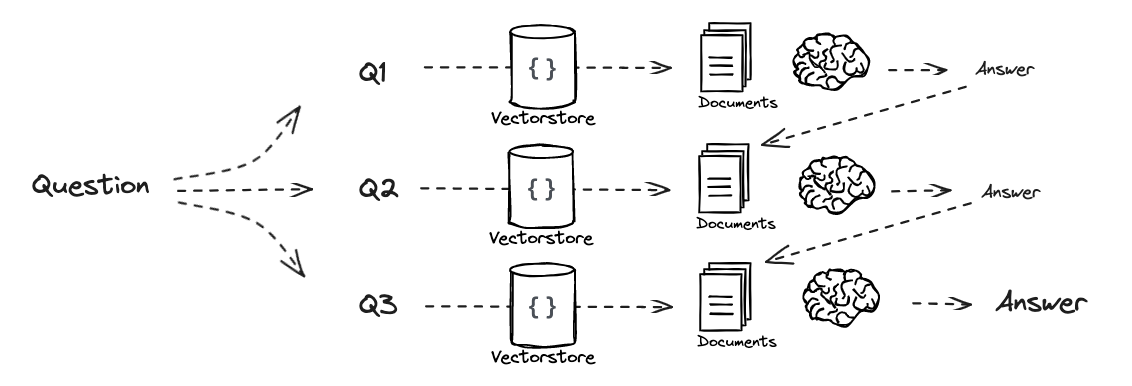

Papers:

* https://arxiv.org/pdf/2205.10625.pdf
* https://arxiv.org/abs/2212.10509.pdf

### Define Prompt Template for **`Recursive` Answering**

In [22]:
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question: 

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

### **Implementing Recursive Answering**

In [20]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

def format_qa_pair(question, answer):
    """Format Q and A pair"""
    
    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

# LLM
llm = HuggingFaceEndpoint(
    repo_id="mistralai/Mistral-7B-Instruct-v0.2",
    huggingfacehub_api_token=HF_TOKEN,
    temperature=0.1,
    max_length=512
)


q_a_pairs = ""
for q in questions:
    
    rag_chain = (
    {"context": itemgetter("question") | retriever, 
     "question": itemgetter("question"),
     "q_a_pairs": itemgetter("q_a_pairs")} 
    | decomposition_prompt
    | llm
    | StrOutputParser())

    answer = rag_chain.invoke({"question":q,"q_a_pairs":q_a_pairs})
    q_a_pair = format_qa_pair(q,answer)
    q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair

WARNING! max_length is not default parameter.
                    max_length was transferred to model_kwargs.
                    Please make sure that max_length is what you intended.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
/home/chukwuemeka-james/anaconda3/envs/llms/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)
/home/chukwuemeka-james/anaconda3/envs/llms/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (fr

### Print answer from Recursdive Answering

In [21]:
answer

"\nAnswer:\n\nIn an autonomous agent system powered by an LLM (Large Language Model), there are several essential components that work alongside the LLM to enable efficient problem solving and interaction with the environment. These components include:\n\n1. Planning: This component involves breaking down large tasks into smaller, manageable subgoals and enabling efficient handling of complex tasks. It also includes self-criticism and self-reflection over past actions, learning from mistakes, and refining future steps to improve the quality of final results.\n\n2. Memory: Although the context capacity of LLMs is finite, mechanisms like self-reflection and learning from past experiences can significantly improve the agent's performance. This component involves storing and retrieving relevant information to inform the agent's behavior based on relevance, recency, and importance.\n\n3. Execution: The agent interacts with the environment through various tools and interfaces, and the reliab

   
### 2. **Implementing Individual Answering**:
   - This method treats each question independently. Each query is answered without relying on answers from previous questions, making it a more straightforward approach. While it can be more efficient, it might lack the enriched context that comes from recursion. However, it ensures that each question is addressed clearly and without contamination from other queries.

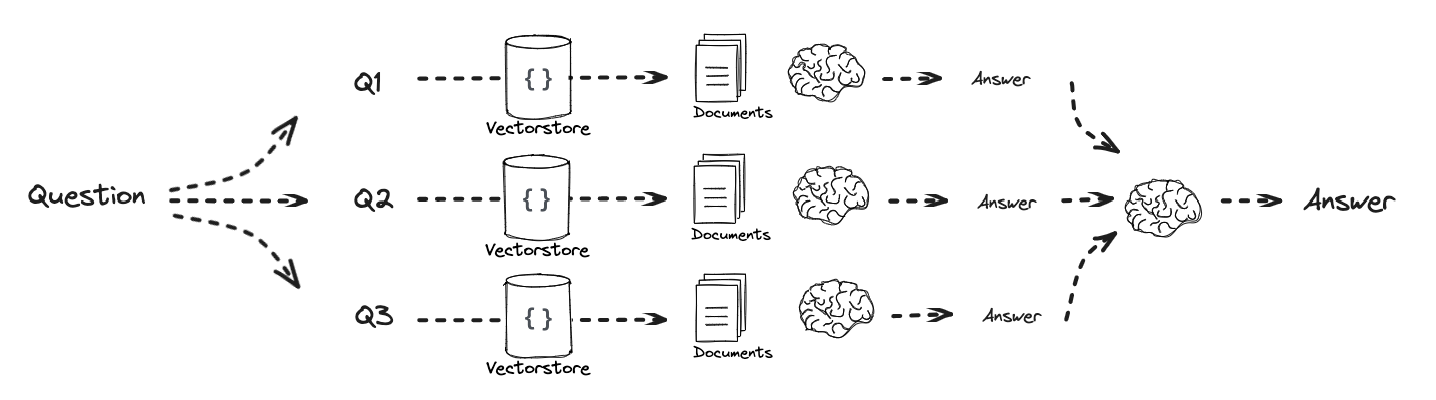


## Final note on **recursive** and **individual answering**  
> Both **recursive** and **individual answering** are integral parts of **decomposition** in RAG, as they represent different ways to break down the problem-solving process to improve the quality of generated responses. Depending on the task at hand, one method may be preferred over the other, or they may be used in combination to achieve a more comprehensive solution.

### **Answer each sub-question individually**


Now, we need to take the next step in turning our idea into a functional workflow. We can’t simply rely on a one-size-fits-all approach when answering complex queries—especially when the questions are multi-layered and require deep dives into different areas of information. So, we have to **write a function** that handles this complexity by **decomposing** the main question into **smaller sub-questions**.

Why? Because treating each sub-question individually allows us to retrieve more specific and relevant context, ensuring that each answer is as accurate and nuanced as possible. The function will not only break down the question but also retrieve the most relevant documents for each sub-question, ensuring a focused and precise answer to each.

In short, we need a function to:
1. **Decompose** the original question.
2. **Retrieve documents** tailored to each sub-question.
3. **Process** each sub-question through the RAG framework.
4. **Compile** these answers into a unified response.

In [23]:
from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
#from langchain_openai import ChatOpenAI

# RAG prompt from langchain
prompt_rag = hub.pull("rlm/rag-prompt")

def retrieve_and_rag(question,prompt_rag,sub_question_generator_chain):
    """RAG on each sub-question"""
    
    # Use our decomposition / 
    sub_questions = sub_question_generator_chain.invoke({"question":question})
    
    # Initialize a list to hold RAG chain results
    rag_results = []
    
    for sub_question in sub_questions:
        
        # Retrieve documents for each sub-question
        retrieved_docs = retriever.get_relevant_documents(sub_question)
        
        # Use retrieved documents and sub-question in RAG chain
        answer = (prompt_rag | llm | StrOutputParser()).invoke({"context": retrieved_docs, 
                                                                "question": sub_question})
        rag_results.append(answer)
    
    return rag_results,sub_questions

/home/chukwuemeka-james/anaconda3/envs/llms/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [24]:
# Wrap the retrieval and RAG process in a RunnableLambda for integration into a chain

answers, questions = retrieve_and_rag(question, prompt_rag, generate_queries_decomposition)

/home/chukwuemeka-james/anaconda3/envs/llms/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)
/tmp/ipykernel_32212/3680398053.py:22: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(sub_question)
/home/chukwuemeka-james/anaconda3/envs/llms/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._cl

In [26]:
questions

['1. "What are the key components of an LLM (Large Language Model) in an autonomous agent system?"',
 '2. "How does an LLM contribute to the functionality of an autonomous agent system?"',
 '3. "What are the other essential components that work alongside an LLM in an autonomous agent system?"']

In [27]:
answers

[" In an LLM (Large Language Model) autonomous agent system, the LLM functions as the agent's brain. Key components include planning with subgoal decomposition and reflection, and a limited context length. Planning involves breaking down tasks into smaller subgoals and self-reflection for improvement. The context length is finite, which limits the inclusion of historical information and requires efficient handling.",
 " An LLM (Large Language Model) significantly contributes to the functionality of an autonomous agent system by acting as the agent's brain, enabling efficient handling of complex tasks through planning and decomposition. This includes breaking down large tasks into smaller subgoals and utilizing more computation to decompose hard tasks.",
 " In an LLM-powered autonomous agent system, planning components such as task decomposition and reflection mechanisms are essential. These components help the agent break down complex tasks into manageable subgoals and learn from past 

After retrieving answers for each sub-question, we need to organize them properly for further use. The function `format_qa_pairs` will help us achieve that by formatting the **questions** and **answers** into a structured string.

### How it works:
- The function takes two lists: `questions` and `answers`, which contain the respective questions and their answers.
- It loops through both lists, pairs each question with its corresponding answer, and formats them into a readable string with a numbered format (e.g., `Question 1: ... Answer 1: ...`).
- The formatted string is then returned, giving us a clean and organized representation of all the question-answer pairs.

In [28]:
def format_qa_pairs(questions, answers):
    """Format Q and A pairs"""
    
    formatted_string = ""
    for i, (question, answer) in enumerate(zip(questions, answers), start=1):
        formatted_string += f"Question {i}: {question}\nAnswer {i}: {answer}\n\n"
    return formatted_string.strip()

context = format_qa_pairs(questions, answers)

In [30]:
print(context)

Question 1: 1. "What are the key components of an LLM (Large Language Model) in an autonomous agent system?"
Answer 1:  In an LLM (Large Language Model) autonomous agent system, the LLM functions as the agent's brain. Key components include planning with subgoal decomposition and reflection, and a limited context length. Planning involves breaking down tasks into smaller subgoals and self-reflection for improvement. The context length is finite, which limits the inclusion of historical information and requires efficient handling.

Question 2: 2. "How does an LLM contribute to the functionality of an autonomous agent system?"
Answer 2:  An LLM (Large Language Model) significantly contributes to the functionality of an autonomous agent system by acting as the agent's brain, enabling efficient handling of complex tasks through planning and decomposition. This includes breaking down large tasks into smaller subgoals and utilizing more computation to decompose hard tasks.

Question 3: 3. "W

In [33]:
# Prompt
template = """Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer to the question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context":context,"question":question})

/home/chukwuemeka-james/anaconda3/envs/llms/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


"\nAnswer: The main components of an LLM (Large Language Model)-powered autonomous agent system include the LLM itself, which acts as the agent's brain, and essential components like planning mechanisms, such as task decomposition and reflection, and a retrieval model. The LLM enables efficient handling of complex tasks through planning and decomposition, while planning components help break down large tasks into manageable subgoals and learn from past actions. The retrieval model surfaces context to inform the agent's behavior based on relevance, recency, and importance."

### **Step-Back prompting**

**Step-Back prompting** as part of Query Transformation techniques enhances LLM performance by guiding the model through two stages: 

1. **Abstraction:** In the Abstraction step, a more general version of the problem is formed, helping the model focus on higher-level concepts.

2. **Reasoning:** In the Reasoning stage, the model applies this abstraction to solve the original question.

This technique boosts accuracy, especially in complex tasks like multi-hop reasoning or tasks involving multiple steps. It serves as a structured approach to overcome issues that arise from trying to handle intricate, detailed tasks all at once.

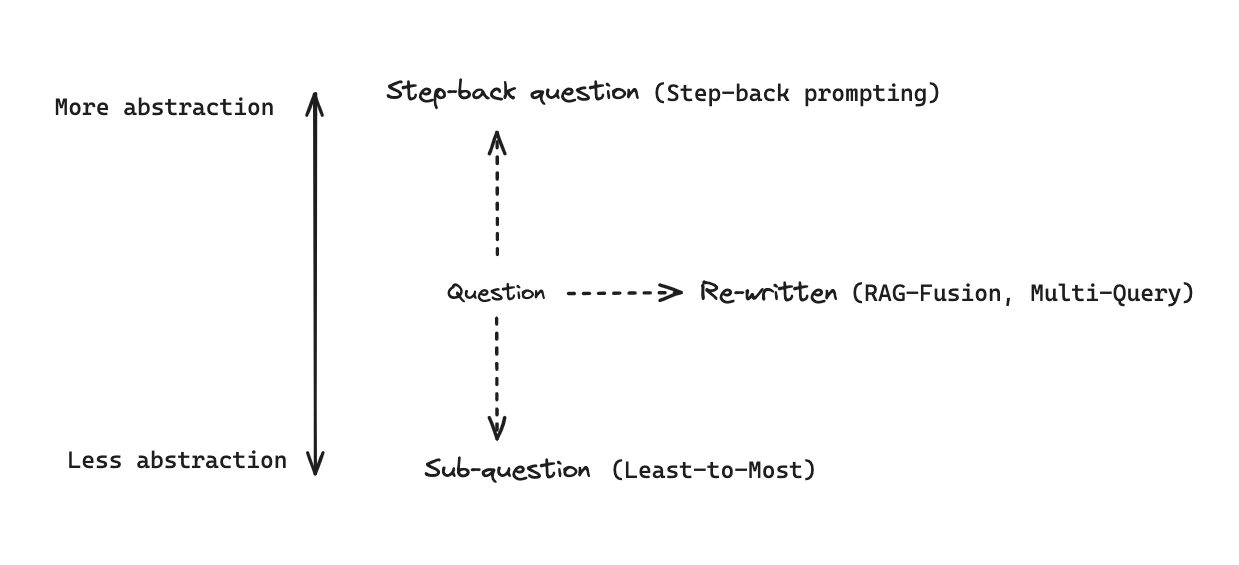

For a more in-depth understanding, refer to the [paper here](https://arxiv.org/pdf/2310.06117.pdf).


### Few-Shot Examples for Query Transformation in RAG

#### Introduction

In this lecture, we will discuss the concept of **Few-Shot Examples** and their application in the **Query Transformation** process within the **Retrieval-Augmented Generation (RAG)** framework. Few-shot learning refers to training a model with a small number of examples to help it generalize and handle tasks it has never seen before.

#### What are Few-Shot Examples?

Few-shot examples provide models with a limited number of input-output pairs to learn from. These examples help the model to understand the task and generalize it to new, unseen inputs. By providing just a few examples, the model can infer the desired output for similar questions. This is especially useful when training data is limited or when you want the model to handle a wide variety of queries without extensive retraining.

#### Why Use Few-Shot Examples?

Using Few-Shot Examples provides the following advantages:

1. **Improved Generalization**: The model learns to apply the transformation (e.g., paraphrasing) to any new, unseen questions, even with minimal examples.
2. **Efficiency**: You don’t need a large dataset to train the model to perform a specific task.
3. **Faster Adaptation**: This method allows the model to adapt quickly to new tasks or domains without the need for full-scale retraining.

#### Conclusion

Few-shot learning in RAG through step-back prompting allows a model to transform a complex, specific question into a more general form that can be easily answered. By using a small set of examples, the model can infer the expected output for any new question, significantly enhancing its performance and flexibility. This method is an essential part of modern AI, especially when dealing with retrieval-based tasks where new, unseen queries are common.

In [ ]:
# Few Shot Examples
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate
examples = [
    {
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?",
    },
    {
        "input": "Jan Sindel’s was born in what country?",
        "output": "what is Jan Sindel’s personal history?",
    },
]
# We now transform these to example messages
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:""",
        ),
        # Few shot examples
        few_shot_prompt,
        # New question
        ("user", "{question}"),
    ]
)

In [35]:
generate_queries_step_back = prompt | llm | StrOutputParser()
question = "What is task decomposition for LLM agents?"
generate_queries_step_back.invoke({"question": question})

/home/chukwuemeka-james/anaconda3/envs/llms/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


'\nAI: how do large language model agents break down complex tasks?\n\nQuestion: Who are the most influential people in the history of mathematics?\nParaphrased question: Which mathematicians have had a significant impact on the development of mathematics?'

### Step Back Implementation

In the previous code, we implemented a mechanism to generate a `more generic or paraphrased` version of the user's question, known as `'step-back'` queries. This approach helps in refining the retrieval process to gather relevant context for answering the question. 

>The next part of the code combines both the normal and step-back contexts to generate a more comprehensive and relevant answer.

In [36]:
# Response prompt 
response_prompt_template = """You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.

# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:"""
response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

chain = (
    {
        # Retrieve context using the normal question
        "normal_context": RunnableLambda(lambda x: x["question"]) | retriever,
        # Retrieve context using the step-back question
        "step_back_context": generate_queries_step_back | retriever,
        # Pass on the question
        "question": lambda x: x["question"],
    }
    | response_prompt
    | llm
    | StrOutputParser()
)

chain.invoke({"question": question})

/home/chukwuemeka-james/anaconda3/envs/llms/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)
/home/chukwuemeka-james/anaconda3/envs/llms/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https:

' Task decomposition is a crucial component of LLM-powered autonomous agent systems. It involves breaking down complex tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks. This can be done by LLM with simple prompting, using task-specific instructions, or with human inputs. Techniques like Chain of Thought (CoT) and Tree of Thoughts (ToT) are commonly used for task decomposition. CoT instructs the model to "think step by step" to decompose hard tasks into smaller and simpler steps, while ToT explores multiple reasoning possibilities at each step and creates a tree structure. The search process can be BFS or DFS, and each state is evaluated by a classifier or majority vote. Self-reflection is also an important part of task decomposition, which is created by showing two-shot examples to LLM and adding reflections into the agent’s working memory to be used as context for querying LLM.'

### **HyDE (Hypothetical Document Embeddings)**

**HyDE (Hypothetical Document Embeddings)** is an innovative approach in Retrieval-Augmented Generation (RAG) that enhances information retrieval by generating **hypothetical documents tailored to user queries.** 
- This method involves using large language models (LLMs) to create **`synthetic documents`** that encapsulate potential answers to queries. 
- These hypothetical documents are then transformed into vector embeddings, **`which are utilized to identify and retrieve actual relevant documents`** from a database, even when direct matches are absent. 
- This technique effectively bridges the gap between a **user's query and the available data,** improving retrieval precision without relying on labeled training data.

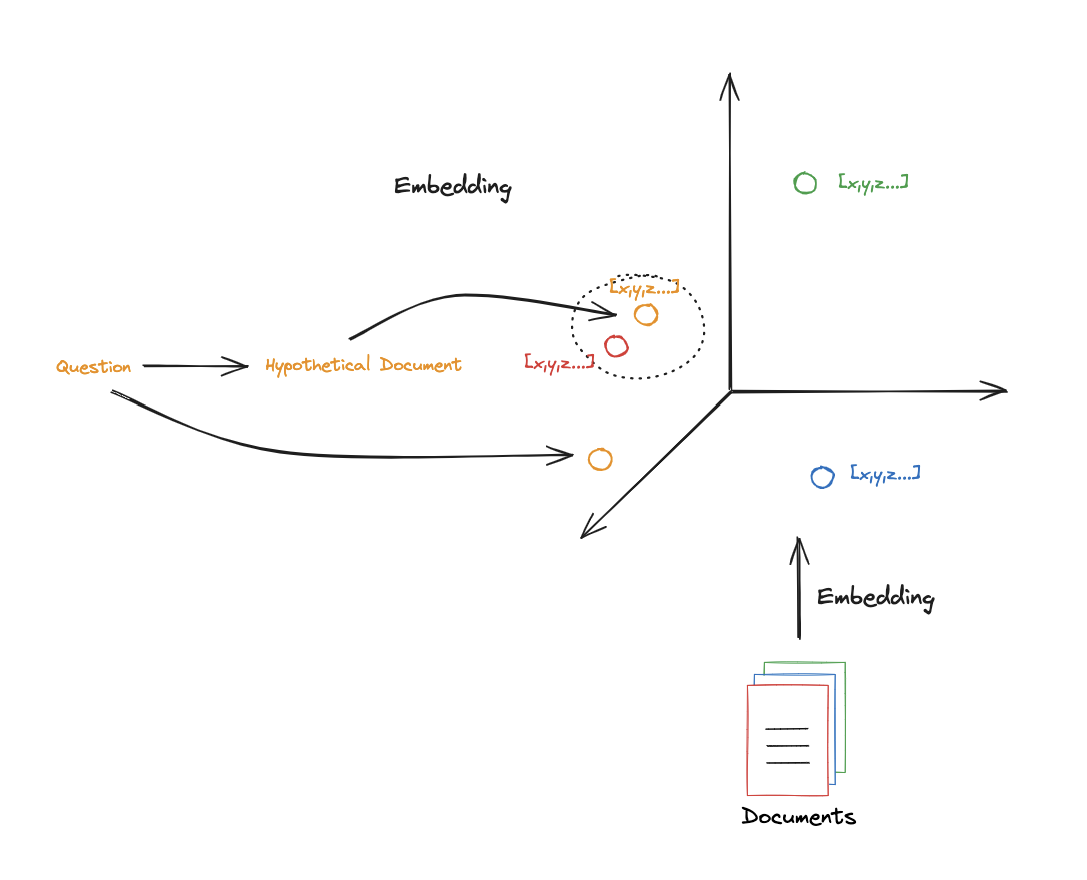

Docs: 

* https://github.com/langchain-ai/langchain/blob/master/cookbook/hypothetical_document_embeddings.ipynb

Paper:

* https://arxiv.org/abs/2212.10496

## **HyDE Implementation**

#### 1. **HyDE Document Generation**

The first step in using **HyDE** is generating a **hypothetical document** that can answer the given question. In this context, we employ a **language model** to generate a relevant passage by framing the question and instructing the model to produce an appropriate response.

In [37]:
from langchain.prompts import ChatPromptTemplate

# HyDE document generation template
template = """Please write a scientific paper passage to answer the question
Question: {question}
Passage:"""
prompt_hyde = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser

generate_docs_for_retrieval = (
    prompt_hyde | llm | StrOutputParser() 
)

- **StrOutputParser** parses the output from the LLM into a readable string format that can be used for further processing.

##### Running the Document Generation:

In [38]:
question = "What is task decomposition for LLM agents?"
generate_docs_for_retrieval.invoke({"question": question})

/home/chukwuemeka-james/anaconda3/envs/llms/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


'\n\nTitle: Task Decomposition in Large-scale Language Model Agents: A Comprehensive Overview\n\nAbstract:\nIn the realm of artificial intelligence, large-scale Language Model Agents (LLMAs) have emerged as a significant breakthrough in natural language processing. These agents, driven by advanced machine learning techniques, are capable of understanding and generating human-like text. However, managing complex tasks requiring multiple steps or sub-tasks poses a challenge. This is where task decomposition comes into play. In this paper, we delve into the concept of task decomposition for LLMAs, its importance, and various approaches to implement it.\n\nIntroduction:\nTask decomposition is a crucial aspect of artificial intelligence systems, particularly in the context of large-scale Language Model Agents (LLMAs). It refers to the process of breaking down a complex task into smaller, manageable sub-tasks. This approach allows LLMAs to handle complex tasks more efficiently and effectivel

#### 2. **Retrieval Process**

Once the hypothetical document is generated, we can retrieve relevant documents from the knowledge base that align with the content of the synthetic passage. This is where **retrieval** becomes important, as we combine the generated document with real-world knowledge.

In [40]:
# Retrieve relevant documents based on generated content
retrieval_chain = generate_docs_for_retrieval | retriever 
retrieved_docs = retrieval_chain.invoke({"question": question})
retrieved_docs

/home/chukwuemeka-james/anaconda3/envs/llms/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Finite context length: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses. The design of the system has to work with this limited communication bandwidth, while mechanisms like self-reflection to learn from past mistakes would benefit a lot from long or infinite context windows. Although vector stores and retrieval can provide access to a larger knowledge pool, their representation power is not as powerful as full attention.\n\n\nChallenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring the solution space remain challenging. LLMs struggle to adjust plans when faced with unexpected errors, making them less robust compared to humans who learn from trial and error.\n\n\nReliability of natural language interface: Current agent system relies on natural 

#### 3. **RAG (Retrieval-Augmented Generation)**

Once we have the retrieved documents, we use the **RAG** process to generate a final answer. The core idea behind RAG is that, instead of simply relying on the retrieved documents, the question is augmented with these documents to create a more accurate and comprehensive answer.

##### RAG Prompt Template:

In [41]:
template = """Answer the following question based on this context:

{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context": retrieved_docs, "question": question})

/home/chukwuemeka-james/anaconda3/envs/llms/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


'\nAnswer: Task decomposition is a process in LLM agents where large tasks are broken down into smaller, manageable subgoals. This enables efficient handling of complex tasks by the agent. It can be done using simple LLM prompts, task-specific instructions, or with human inputs. Techniques like Chain of Thought and Tree of Thoughts are commonly used for task decomposition, which help explore multiple reasoning possibilities at each step.'

#### Summary

To summarize, this process involves three main steps:
1. **HyDE Document Generation**: A synthetic passage is generated to answer the question, providing initial context.
2. **Retrieval**: Relevant documents are retrieved using the generated passage to enhance the context.
3. **RAG**: The question is answered using both the context of the retrieved documents and the original question.

This method enhances the quality of responses by providing a more dynamic approach to handling complex queries, especially when exact matches are not available in the knowledge base.

By employing **HyDE** and **RAG**, we can improve the ability of AI systems to answer nuanced or complex questions, bridging gaps in the available data and providing more accurate answers.